## Thomson Problem - Coulomb Charges on a Sphere

Author: Roman Aseguinolaza Gallo

Consider N Coulomb charges with their movement restricted to a unit sphere.

Using an annealing procedure, find optimal positions for different numbers of particles. Spherical coordinates can be used to generate valid displacements:

$$ r = (x, y, z) = (p, 0, 0) \rightarrow r' = (p, 0', 0') = (x', y', z') $$

so that angles $0$ and $0'$ are changed while $p$ is kept fixed.

**Report**:
- Optimal configuration
- Optimal energy
- The radial distribution function

---

In [1]:
import numpy as np
from numba import njit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import pandas as pd
import pickle

from scipy.spatial import SphericalVoronoi


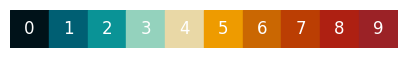

In [2]:
''' Color Palette '''

colors=["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]

fig, ax = plt.subplots(figsize=(5, 0.5), subplot_kw=dict(xticks=[], yticks=[], frame_on=False))
for i, color in enumerate(colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    ax.text(i + 0.5, 0.5, str(i), color='white', ha='center', va='center', fontsize=12)
ax.set_xlim(0, len(colors))
ax.set_ylim(0, 1)
plt.show()


---

### Annealing functions

In [3]:
@njit
def energy(n, x, y, z):
    """
    Calculate the Coulomb potential energy of n particles on a unit sphere.
    
    Args:
        n (int): Number of particles
        x, y, z (ndarray): Cartesian coordinates of particles
    
    Returns:
        float: Total potential energy
    """
    energy = 0.0
    for i in range(n-1):
        for j in range(i+1, n):
            energy += 1.0 / np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2)
    return energy

@njit
def energy_single_particle(n, x, y, z, i):
    """
    Calculate the change in Coulomb potential energy due to the movement of a single particle.
    
    Args:
        n (int): Number of particles
        x, y, z (ndarray): Cartesian coordinates of particles
        i (int): Index of the particle being moved
    
    Returns:
        float: Change in potential energy
    """
    energy = 0.0
    for j in range(n):
        if i != j:
            energy += 1.0 / np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2)
    return energy

@njit
def spherical_to_cartesian(theta, phi):
    """
    Convert spherical coordinates to Cartesian coordinates.
    
    Args:
        theta (float): Polar angle
        phi (float): Azimuthal angle
    
    Returns:
        tuple: (x, y, z) Cartesian coordinates
    """
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z


In [4]:
@njit
def annealing(n, m, T, a0):
    """
    Simulated annealing optimization for particle positions on sphere.
    First particle is fixed at the north pole (0, 0, 1).
    
    Args:
        n (int): Number of particles
        m (int): Number of Monte Carlo steps
        T (float): Initial temperature
        a0 (float): Initial step size parameter
    
    Returns:
        tuple: Final (x, y, z) coordinates of particles
    """
    # Initialize first particle at north pole
    theta = np.zeros(n)
    phi = np.zeros(n)
    
    # Initialize other particles randomly
    theta[1:] = np.arccos(2.0 * np.random.rand(n-1) - 1.0)
    phi[1:] = 2.0 * np.pi * np.random.rand(n-1)
    
    x, y, z = spherical_to_cartesian(theta, phi)

    for j in range(m):
        T *= 0.9999
        a = a0 * np.sqrt(T)
        
        # Create new configuration (keeping first particle fixed)
        theta_new = theta.copy()
        phi_new = phi.copy()
        theta_new[1:] = theta[1:] + a * (2.0 * np.random.rand(n-1) - 1.0)
        phi_new[1:] = phi[1:] + a * (2.0 * np.random.rand(n-1) - 1.0)
        
        x_new, y_new, z_new = spherical_to_cartesian(theta_new, phi_new)
        
        energy_old = energy(n, x, y, z)
        energy_new = energy(n, x_new, y_new, z_new)
        
        w = np.exp(-(energy_new - energy_old) / T)
        
        if np.random.rand() < w:
            x, y, z = x_new, y_new, z_new
            theta, phi = theta_new, phi_new
    
    return x, y, z

@njit
def annealing_single(n, m, T, a0):
    """
    Simulated annealing optimization for particle positions on sphere.
    First particle is fixed at the north pole (0, 0, 1).
    
    Args:
        n (int): Number of particles
        m (int): Number of Monte Carlo steps
        T (float): Initial temperature
        a0 (float): Initial step size parameter
    
    Returns:
        tuple: Final (x, y, z) coordinates of particles
    """
    # Initialize first particle at north pole
    theta = np.zeros(n)
    phi = np.zeros(n)
    
    # Initialize other particles randomly
    theta[1:] = np.arccos(2.0 * np.random.rand(n-1) - 1.0)
    phi[1:] = 2.0 * np.pi * np.random.rand(n-1)
    
    x, y, z = spherical_to_cartesian(theta, phi)

    for j in range(m):
        T *= 0.99999
        a = a0 * np.sqrt(T)
        
        # Select a random particle to move (excluding the first particle)
        i = np.random.randint(1, n)
        
        # Create new configuration for the selected particle
        theta_new = theta[i] + a * (2.0 * np.random.rand() - 1.0)
        phi_new = phi[i] + a * (2.0 * np.random.rand() - 1.0)
        
        x_new, y_new, z_new = spherical_to_cartesian(theta_new, phi_new)
        
        # Calculate the change in energy due to the movement of the selected particle
        energy_old = energy_single_particle(n, x, y, z, i)
        x[i], y[i], z[i] = x_new, y_new, z_new
        energy_new = energy_single_particle(n, x, y, z, i)
        
        # Metropolis criterion
        w = np.exp(-(energy_new - energy_old) / T)
        
        if np.random.rand() >= w:
            # Revert the move if not accepted
            x[i], y[i], z[i] = spherical_to_cartesian(theta[i], phi[i])
        else:
            # Update the angles if the move is accepted
            theta[i], phi[i] = theta_new, phi_new
    
    return x, y, z


---

### Plotting optimal configurations

In [ ]:
def plot_configuration(n, x, y, z, ax):
    """
    Plot particles on unit sphere with connections between nearby particles.
    
    Args:
        n (int): Number of particles
        x, y, z (ndarray): Particle coordinates
        ax (Axes3D): Matplotlib 3D axis for plotting
    """
    # Generate sphere surface points
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    sphere_x = np.outer(np.cos(u), np.sin(v))
    sphere_y = np.outer(np.sin(u), np.sin(v))
    sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Plot semi-transparent sphere
    ax.plot_surface(sphere_x, sphere_y, sphere_z, color=colors[4], alpha=0.1)
    
    # Plot particles with a nice color
    ax.scatter(x, y, z, c=colors[9], s=150, linewidth=0.5)
    
    # Find shortest distance between particles to determine connections
    shortest_dist = float('inf')
    for i in range(n-1):
        for j in range(i+1, n):
            dist = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2 + (z[i]-z[j])**2)
            shortest_dist = min(shortest_dist, dist)
    
    # Draw connections between nearby particles
    for i in range(n):
        for j in range(i+1, n):
            dist = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2 + (z[i]-z[j])**2)
            if dist < shortest_dist * 1.2:
                ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 
                       color=colors[7], linewidth=1, alpha=0.6)
    
    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])
    
    # Remove the box
    ax.set_axis_off()
    
    # Set viewing angle
    ax.view_init(elev=20, azim=45)

def plot_voronoi(n, x, y, z, ax, s=0):
    """
    Plot Voronoi diagram for particles on unit sphere.
    
    Args:
        n (int): Number of particles
        x, y, z (ndarray): Particle coordinates
        ax (Axes3D): Matplotlib 3D axis for plotting
    """
    # Create SphericalVoronoi object
    points = np.vstack((x, y, z)).T
    sv = SphericalVoronoi(points)
    sv.sort_vertices_of_regions()
    
    # Define colors for different polygon types
    polygon_colors = {
        3: colors[3],  # Triangles
        4: colors[9],  # Quadrilaterals
        5: colors[2],  # Pentagons
        6: colors[7],  # Hexagons
        7: colors[1],  # Heptagons
        8: colors[4],  # Octagons
        'default': colors[2]  # Default color for other polygons
    }
    
    # Plot Voronoi regions
    for region in sv.regions:
        polygon = [sv.vertices[i] for i in region]
        num_sides = len(polygon)
        color = polygon_colors.get(num_sides, polygon_colors['default'])
        poly = Poly3DCollection([polygon], alpha=0.6, edgecolor='k')
        poly.set_facecolor(color)
        ax.add_collection3d(poly)
    
    # Plot particles
    ax.scatter(x, y, z, c=colors[9], s=s, linewidth=0.5)
    
    # Plot semi-transparent sphere
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    sphere_x = np.outer(np.cos(u), np.sin(v))
    sphere_y = np.outer(np.sin(u), np.sin(v))
    sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(sphere_x, sphere_y, sphere_z, color=colors[4], alpha=0.1)
    
    # Set equal aspect ratio
    ax.set_box_aspect([1,1,1])
    
    # Remove the box
    ax.set_axis_off()
    
    # Set viewing angle
    ax.view_init(elev=20, azim=45)


N=4: Energy = 3.6744506715048715
N=5: Energy = 6.4748149883608095
N=6: Energy = 9.985472703868812
N=7: Energy = 14.453216157434145
N=8: Energy = 19.6758133024456
N=9: Energy = 25.760249963475374
N=10: Energy = 32.71716375841337
N=11: Energy = 40.596736288541095
N=12: Energy = 49.16558323455449
Saving plot to 'optimal_configurations.png'


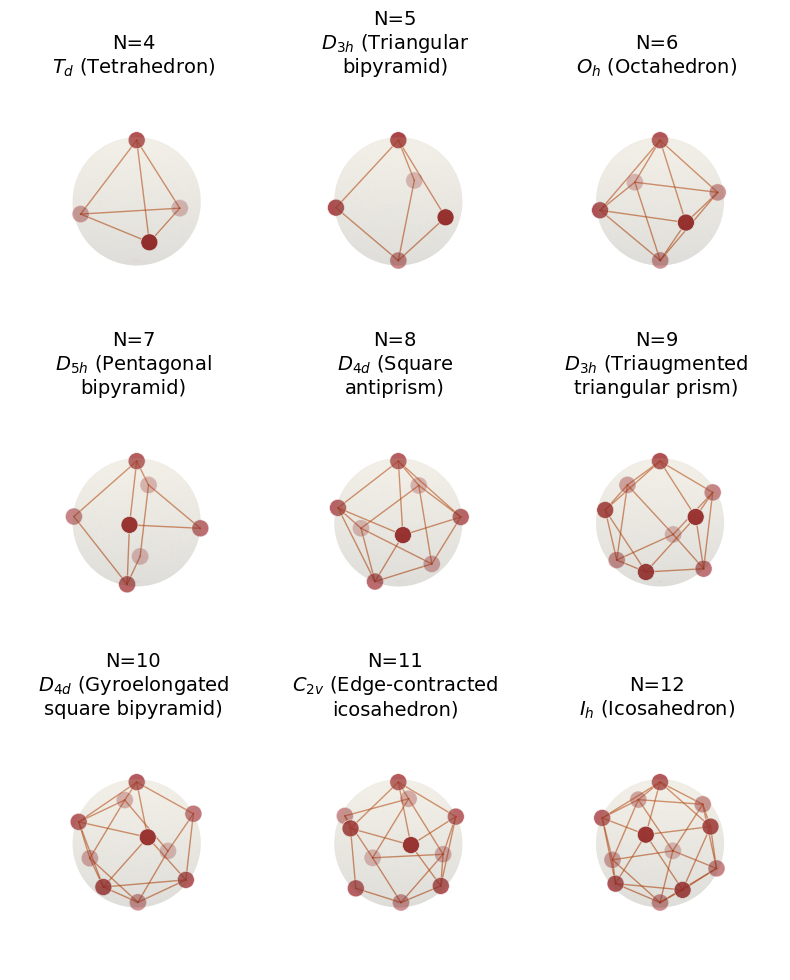

In [31]:
def generate_all_configurations():
    """
    Generate and plot optimal configurations for 4-12 particles on a sphere.
    Shows typical geometric arrangements like tetrahedron, octahedron, etc.
    """
    fig = plt.figure(figsize=(8, 10))
    
    m = 1000000  # Number of Monte Carlo steps
    T = 1.0     # Initial temperature
    a0 = 0.5    # Position update parameter
    
    names = {
        3: "$D_{3h}$ (Triangle)",
        4: "$T_{d}$ (Tetrahedron)",
        5: "$D_{3h}$ (Triangular\nbipyramid)",
        6: "$O_{h}$ (Octahedron)",
        7: "$D_{5h}$ (Pentagonal\nbipyramid)",
        8: "$D_{4d}$ (Square\nantiprism)",
        9: "$D_{3h}$ (Triaugmented\ntriangular prism)",
        10: "$D_{4d}$ (Gyroelongated\nsquare bipyramid)",
        11: "$C_{2v}$ (Edge-contracted\nicosahedron)",
        12: "$I_{h}$ (Icosahedron)"
    }
    
    for idx, n in enumerate(range(4, 13), 1):
        ax = fig.add_subplot(3, 3, idx, projection='3d')
        
        x, y, z = annealing_single(n, m, T, a0)
        # Report energy of final configuration
        print(f"N={n}: Energy = {energy(n, x, y, z)}")

        plot_configuration(n, x, y, z, ax)
        
        ax.set_title(f'N={n}\n{names[n]}', fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
    plt.tight_layout()
    # Save with high DPI and tight layout to prevent cropping
    print("Saving plot to 'optimal_configurations.png'")
    plt.savefig('optimal_configurations.png', dpi=1200, bbox_inches='tight')
    # For vector graphics (optional), use:
    # plt.savefig('optimal_configurations.pdf', bbox_inches='tight')
    # plt.close(fig)
    
# Generate all configurations
generate_all_configurations()


N=4: Energy = 3.6742346141747664
N=5: Energy = 6.474691494688161
N=6: Energy = 9.985281374238568
N=7: Energy = 14.452979704812991
N=8: Energy = 19.67528786123276
N=9: Energy = 25.759986531269814
N=10: Energy = 32.716949460147575
N=11: Energy = 40.596620329462674
N=12: Energy = 49.16525305762876
Saving plot to 'voronoi_configurations.png'


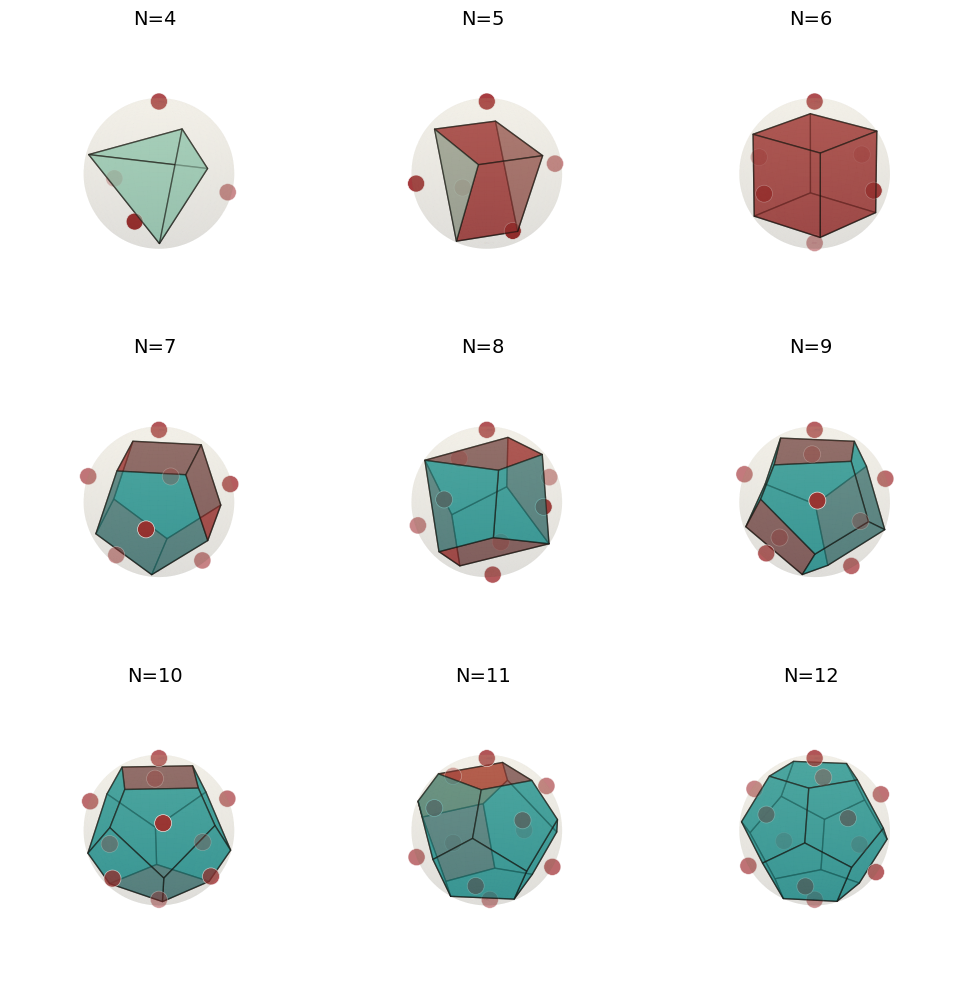

In [ ]:
def generate_voronoi_configurations():
    """
    Generate and plot Voronoi diagrams for 4-12 particles on a sphere.
    """
    fig = plt.figure(figsize=(10, 10))
    
    m = 1000000  # Number of Monte Carlo steps
    T = 1.0     # Initial temperature
    a0 = 0.5    # Position update parameter
    
    names = {
        3: "$D_{3h}$ (Triangle)",
        4: "$T_{d}$ (Tetrahedron)",
        5: "$D_{3h}$ (Triangular\nbipyramid)",
        6: "$O_{h}$ (Octahedron)",
        7: "$D_{5h}$ (Pentagonal\nbipyramid)",
        8: "$D_{4d}$ (Square\nantiprism)",
        9: "$D_{3h}$ (Triaugmented\ntriangular prism)",
        10: "$D_{4d}$ (Gyroelongated\nsquare bipyramid)",
        11: "$C_{2v}$ (Edge-contracted\nicosahedron)",
        12: "$I_{h}$ (Icosahedron)"
    }
    
    for idx, n in enumerate(range(4, 13), 1):
        ax = fig.add_subplot(3, 3, idx, projection='3d')
        
        x, y, z = annealing_single(n, m, T, a0)
        # Report energy of final configuration
        print(f"N={n}: Energy = {energy(n, x, y, z)}")

        plot_voronoi(n, x, y, z, ax, s=150)
        
        ax.set_title(f'N={n}', fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
    plt.tight_layout()
    # Save with high DPI and tight layout to prevent cropping
    print("Saving plot to 'voronoi_configurations.png'")
    plt.savefig('voronoi_configurations.png', dpi=1200, bbox_inches='tight')
    # For vector graphics (optional), use:
    # plt.savefig('voronoi_configurations.pdf', bbox_inches='tight')
    # plt.close(fig)
    
# Generate Voronoi configurations
generate_voronoi_configurations()


---

### Angular distribution function

In [6]:
''' Angular distribution function '''

def calculate_adf(x, y, z, n, nbins=50):
    """
    Calculate angular distribution function for particles on a sphere surface.
    Since the radius is 1, the angle is also the geodesic distance.
    
    Args:
        x, y, z (ndarray): Particle coordinates
        n (int): Number of particles
        nbins (int): Number of histogram bins
    
    Returns:
        tuple: (bin_centers, g(theta))
    """
    # Calculate all pairwise angles
    angles = []
    for i in range(n-1):
        for j in range(i+1, n):
            dot_product = x[i]*x[j] + y[i]*y[j] + z[i]*z[j]
            angle = np.arccos(dot_product)
            angles.append(angle)
    
    # Create histogram (range is [0, pi])
    hist, bins = np.histogram(angles, bins=nbins, range=(0, np.pi), density=False)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    dtheta = np.pi / nbins

    norm = n**2 / 4 * np.sin(bin_centers) * dtheta  # Normalization factor for spherical surface
    g = hist / norm
    
    return bin_centers, g


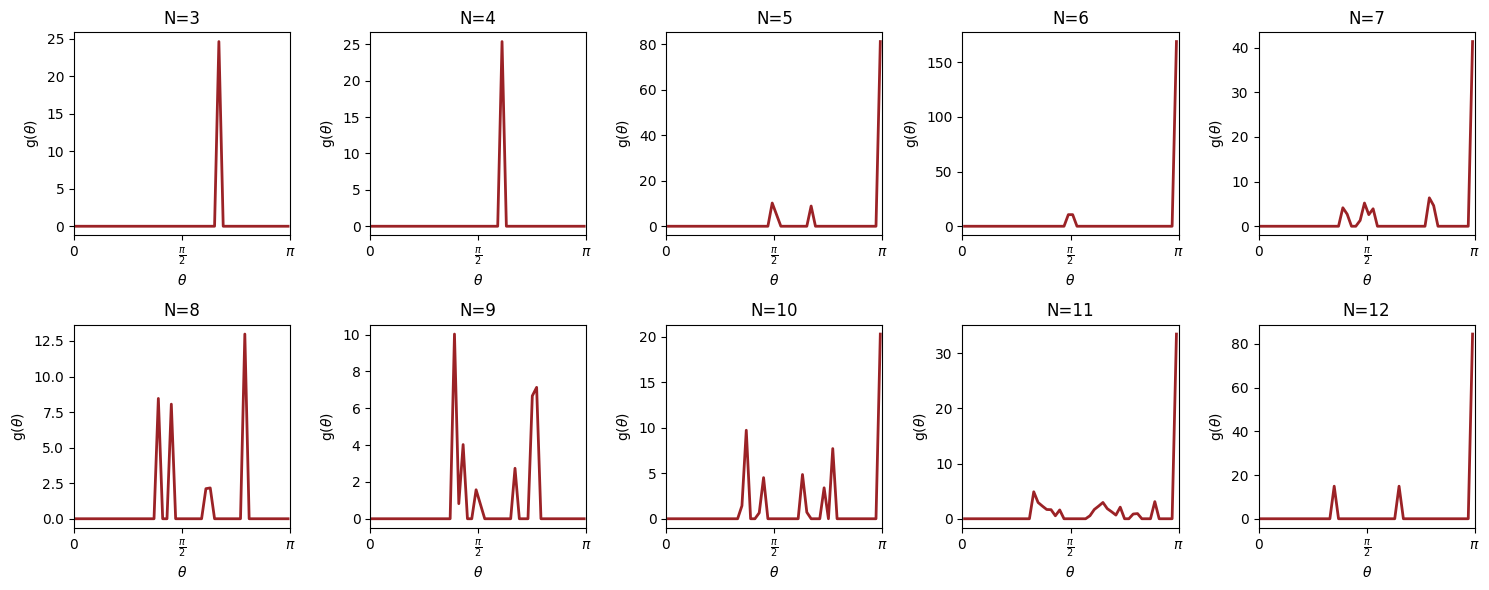

In [7]:
# Plot of angular distribution function for N particles on a sphere

N = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

fig, ax = plt.subplots(2, 5, figsize=(15, 6))

for idx, n in enumerate(N, 1):
    x, y, z = annealing_single(n, 1000000, 1.0, 0.5)
    theta, g_theta = calculate_adf(x, y, z, n)
    
    ax.flat[idx-1].plot(theta, g_theta, color=colors[9], linewidth=2)
    ax.flat[idx-1].set_title(f'N={n}')
    ax.flat[idx-1].set_xlabel(r'$\theta$')
    ax.flat[idx-1].set_ylabel(r'g($\theta$)')
    ax.flat[idx-1].set_xlim(0, np.pi)
    ax.flat[idx-1].set_xticks([0, np.pi/2, np.pi])
    ax.flat[idx-1].set_xticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

plt.tight_layout()
plt.show()


---

### Optimal energy vs N

C:\Users\roman\AppData\Local\Temp\ipykernel_24328\2586520728.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('NUthom.csv', delim_whitespace=True)


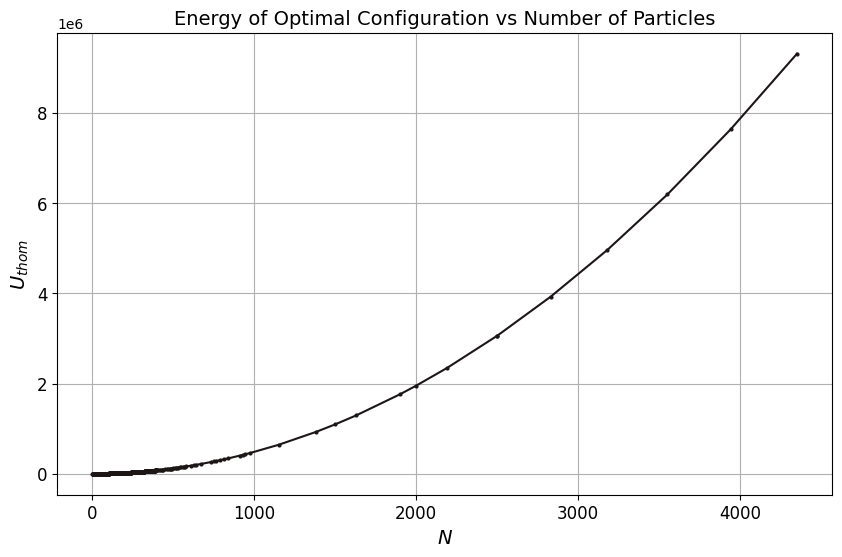

In [9]:
''' Energy of optimal configuration vs number of particles '''

# Read the data from NUthom.csv
data = pd.read_csv('NUthom.csv', delim_whitespace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['N'], data['Uthom'], marker='o', markersize=2, linestyle='-', color='#1D1616')
plt.xlabel('$N$', fontsize=14)
plt.ylabel('$U_{thom}$', fontsize=14)
plt.title('Energy of Optimal Configuration vs Number of Particles', fontsize=14)
# plt.yscale('log')
plt.grid(True)

# Change tick text size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


In [36]:
# Generate energies for spaced values of N from 0 to 1000
N_values = np.linspace(10, 1000, 10, dtype=int)
energies = []

for N in N_values:
    x, y, z = annealing_single(N, 10000000, 1.0, 0.5)
    U = energy(N, x, y, z)
    energies.append(U)

    print(f"N={N}: Energy = {U}")


N=10: Energy = 32.7169494601476
N=120: Energy = 6474.787388631746
N=230: Energy = 24525.121855012083
N=340: Energy = 54340.2364159785
N=450: Energy = 95981.0425047873
N=560: Energy = 149485.06230199535
N=670: Energy = 214879.21194675495
N=780: Energy = 292179.8874969945
N=890: Energy = 381395.4398794092
N=1000: Energy = 482552.07915735384


In [11]:
# Filter N_values to include only those smaller than 500
filtered_N_values = N_values[N_values < 600]

# Calculate the percentual energy errors
percentual_errors = []
for N in filtered_N_values:
    # Get the index of N in N_values
    idx = np.where(N_values == N)[0][0]
    
    # Get the energy from the annealing process
    U_annealing = energies[idx]
    
    # Get the energy from the data
    U_data = data[data['N'] == N]['Uthom'].values[0]
    
    # Calculate the percentual error
    percentual_error = ((U_annealing - U_data) / U_data) * 100
    percentual_errors.append((N, percentual_error))

# Print the percentual errors
for N, error in percentual_errors:
    print(f"N={N}: Percentual Error = {error:.5f}%")


N=10: Percentual Error = 0.00000%
N=120: Percentual Error = 0.00048%
N=230: Percentual Error = 0.00260%
N=340: Percentual Error = 0.00321%
N=450: Percentual Error = 0.00271%
N=560: Percentual Error = 0.00278%


Saving plot to 'energy_vs_N.png'


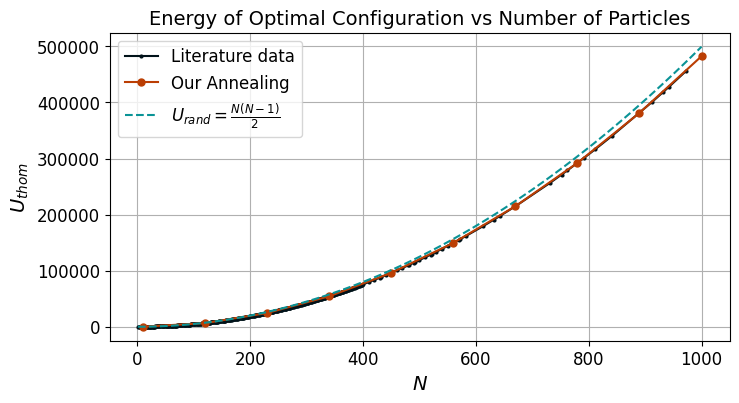

In [12]:
# Filter data to include only up to the largest N in N_values
max_N = max(N_values)
filtered_data = data[data['N'] <= max_N]

# Plot the data
plt.figure(figsize=(8, 4))
plt.plot(filtered_data['N'], filtered_data['Uthom'], marker='o', markersize=2, linestyle='-', color=colors[0], label='Literature data')
plt.plot(N_values, energies, marker='o', markersize=5, linestyle='-', color=colors[7], label='Our Annealing')

# Add N^2/2 line
N_line = np.linspace(1, max_N, 100)
energy_line = N_line*(N_line-1) / 2
plt.plot(N_line, energy_line, linestyle='--', color=colors[2], label='$U_{rand}=\\frac{N(N-1)}{2}$')

plt.xlabel('$N$', fontsize=14)
plt.ylabel('$U_{thom}$', fontsize=14)
plt.title('Energy of Optimal Configuration vs Number of Particles', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Change tick text size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Save with high DPI and tight layout to prevent cropping
print("Saving plot to 'energy_vs_N.png'")
plt.savefig('energy_vs_N.png', dpi=1200, bbox_inches='tight')

plt.show()


---

### N = 18, 100, 500

Saving plot to 'voronoi_18_1000.png'


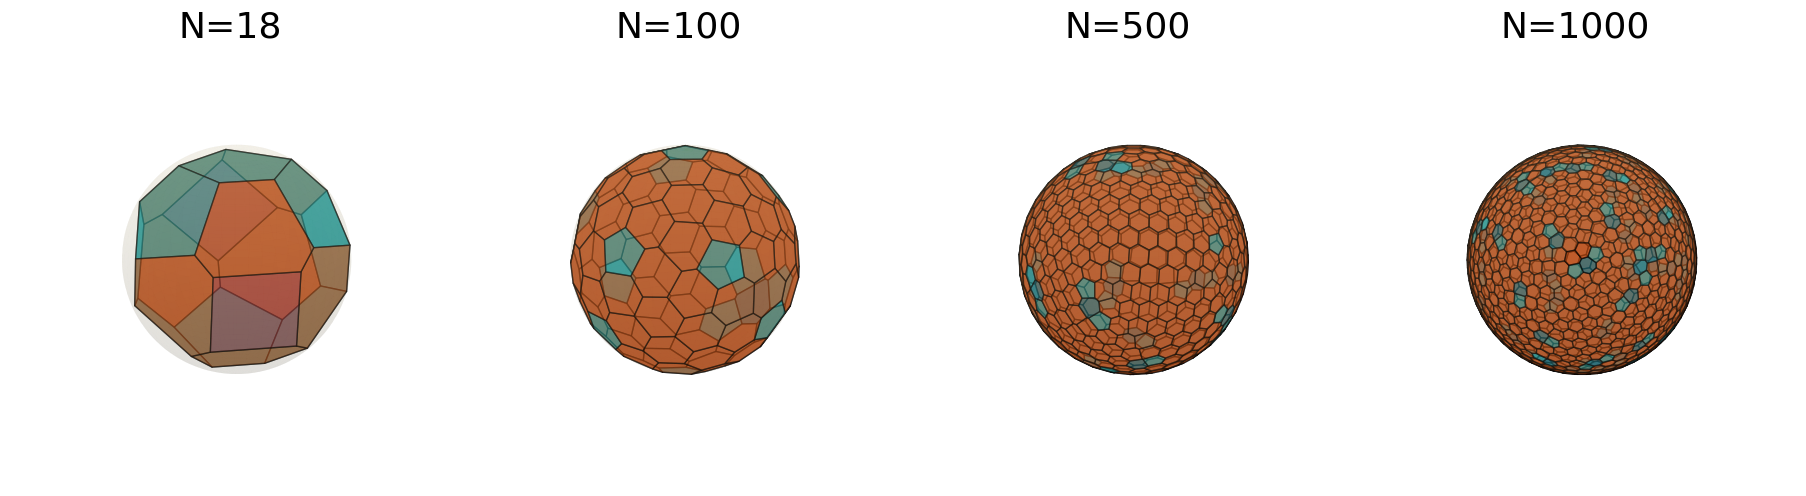

C:\Users\roman\AppData\Local\Temp\ipykernel_24328\817489995.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=16)


Saving plot to 'angular_distribution.png'


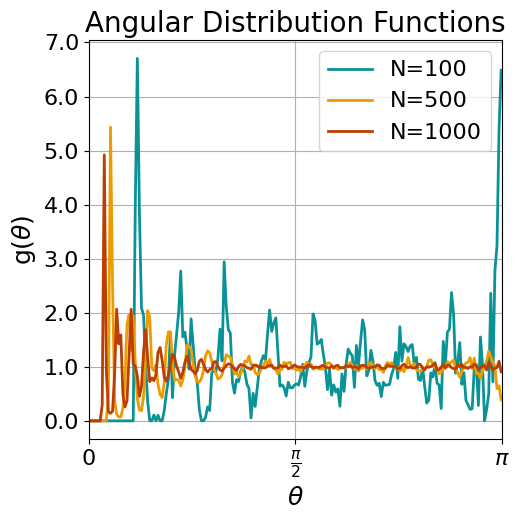

In [15]:
Ns = [18, 100, 500, 1000]

# Generate Voronoi structures
fig = plt.figure(figsize=(18, 6))

coordinates = {}

for idx, N in enumerate(Ns, 1):
    ax = fig.add_subplot(1, 4, idx, projection='3d')
    
    # Generate particle positions using annealing
    x, y, z = annealing_single(N, 100000000, 1.0, 0.5)
    coordinates[N] = (x, y, z)
    
    # Plot Voronoi diagram
    plot_voronoi(N, x, y, z, ax)
    
    ax.set_title(f'N={N}', fontsize=26)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

plt.tight_layout(pad=0.5)
# Save with high DPI and tight layout to prevent cropping
print("Saving plot to 'voronoi_18_1000.png'")
plt.savefig('voronoi_18_1000.png', dpi=1200, bbox_inches='tight')
plt.show()

# Generate angular distribution functions
fig, ax = plt.subplots(figsize=(5, 5))

adf_colors = [colors[2], colors[5], colors[7]]
for i, N in enumerate(Ns[1:]):
    x, y, z = coordinates[N]
    theta, g_theta = calculate_adf(x, y, z, N, nbins=200)
    
    ax.plot(theta, g_theta, label=f'N={N}', linewidth=2, color=adf_colors[i])

ax.set_xlabel(r'$\theta$', fontsize=18)
ax.set_ylabel(r'g($\theta$)', fontsize=18)
ax.set_title('Angular Distribution Functions', fontsize=20)
ax.set_xlim(0, np.pi)
ax.set_xticks([0, np.pi/2, np.pi])
ax.set_xticklabels([r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=16)
ax.set_yticklabels(ax.get_yticks(), fontsize=16)
ax.legend(fontsize=16)
ax.grid(True)

plt.tight_layout(pad=0.0)
# Save with high DPI and tight layout to prevent cropping
print("Saving plot to 'angular_distribution.png'")
plt.savefig('angular_distribution.png', dpi=1200, bbox_inches='tight')
plt.show()
